### Importar Bibliotecas

In [14]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

palette = "Set2"
sns.set(style="whitegrid", font_scale=0.8, palette=palette)

from dataset import HPADatasetFourChannelsImages as HPADataset
from dataset import classes_map
from utils import train_valid_split_multilabel, train_transformations, valid_transformations
from models import SqueezeNetCAM
from train import train_squeeze_cam

### Carregar Modelo

In [2]:
# Instanciar o modelo
model = SqueezeNetCAM(num_classes=19)

### Carregar Dados

In [3]:
# Imagens e rótulos
dataset_dir = '/mnt/ssd/hpa-single-cell-image-classification/join_resized_train'
labels_csv = '/mnt/ssd/hpa-single-cell-image-classification/train.csv'

# Pesos das classes
class_weights = [0.1, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 10.0, 1.0, 0.5, 0.5, 5.0, 0.2, 0.5, 1.0]

# Converter para torch tensor e garantir que seja do tipo float
class_weights = torch.tensor(class_weights, dtype=torch.float32)

In [5]:
train, valid = train_valid_split_multilabel(
    hpa_dataset_class=HPADataset,
    dataset_dir=dataset_dir,
    labels_csv=labels_csv,
    train_transform=train_transformations(),
    valid_transform=valid_transformations(),
    test_size=0.2,
    random_state=78)

In [7]:
print(f"Número de classes: {len(class_weights)}")
print(f"Pesos das classes: {class_weights}")
print(f"Quantidade das classes: {train.binary_labels.sum(axis=0)}")
print(f"Soma dos pesos: {class_weights.sum()}")
print(f"Nome das classes: {classes_map}")

Número de classes: 19
Pesos das classes: tensor([ 0.1000,  1.0000,  0.5000,  1.0000,  1.0000,  1.0000,  1.0000,  0.5000,
         1.0000,  1.0000,  1.0000, 10.0000,  1.0000,  0.5000,  0.5000,  5.0000,
         0.2000,  0.5000,  1.0000])
Quantidade das classes: tensor([6961.,  874., 1997., 1003., 1146., 1420.,  627., 1462.,  785.,  795.,
         659.,   64., 1404., 2515., 1587.,  203., 4552.,  496.,   28.])
Soma dos pesos: 27.799999237060547
Nome das classes: {0: 'Nucleoplasm', 1: 'Nuclear membrane', 2: 'Nucleoli', 3: 'Nucleoli fibrillar center', 4: 'Nuclear speckles', 5: 'Nuclear bodies', 6: 'Endoplasmic reticulum', 7: 'Golgi apparatus', 8: 'Intermediate filaments', 9: 'Actin filaments', 10: 'Microtubules', 11: 'Mitotic spindle', 12: 'Centrosome', 13: 'Plasma membrane', 14: 'Mitochondria', 15: 'Aggresome', 16: 'Cytosol', 17: 'Vesicles and punctate cytosolic patterns', 18: 'Negative'}


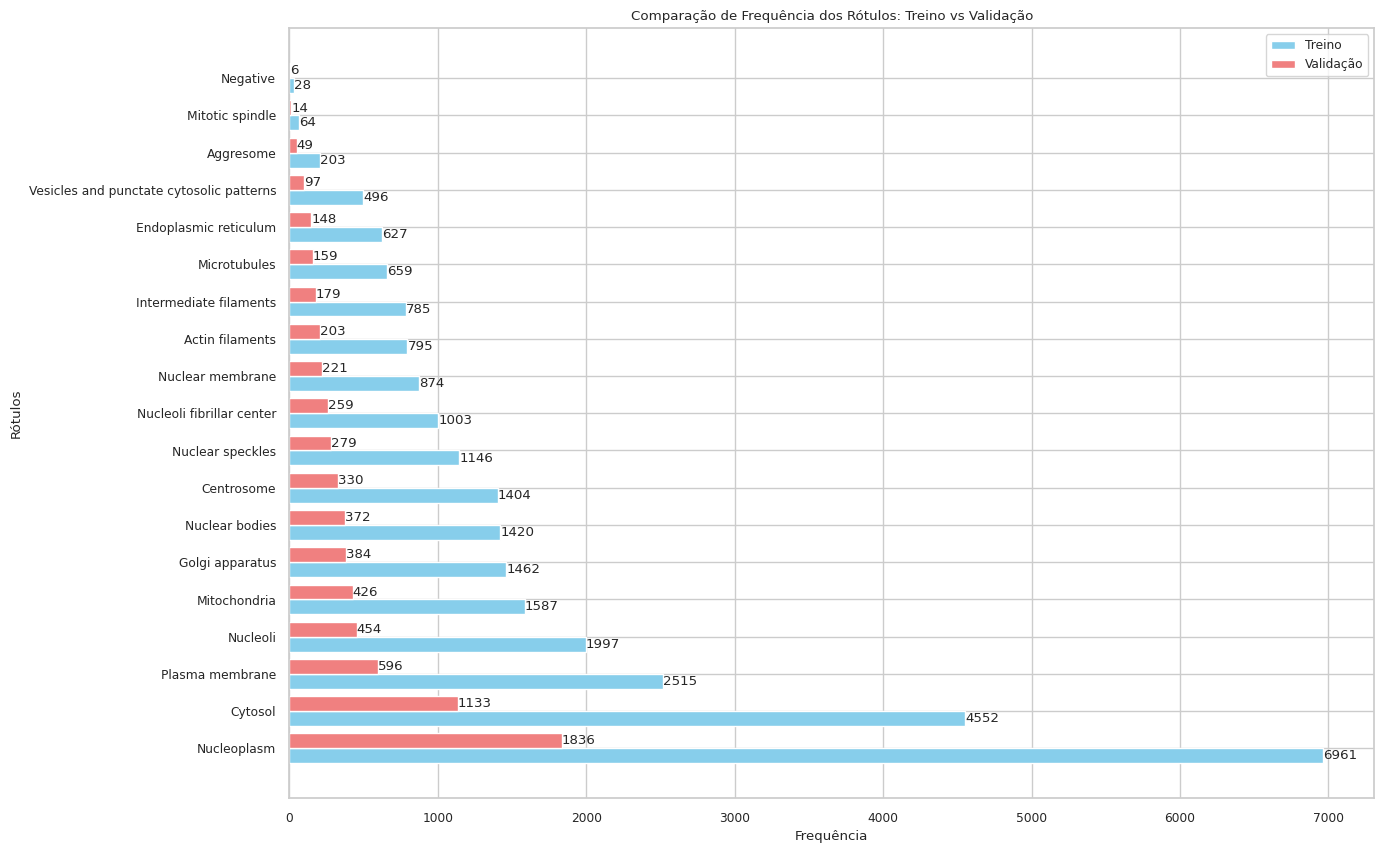

In [8]:
def plot_label_distribution(train_dataset, valid_dataset, classes_map):
    def get_label_counts(dataset):
        label_counts = dataset.binary_labels.sum(axis=0)
        label_counts_named = {classes_map[i]: count for i, count in enumerate(label_counts)}
        sorted_label_counts_named = dict(sorted(label_counts_named.items(), key=lambda item: item[1], reverse=True))
        return sorted_label_counts_named

    # Obter a distribuição dos rótulos nos conjuntos de treino e validação
    train_label_counts = get_label_counts(train_dataset)
    valid_label_counts = get_label_counts(valid_dataset)

    # Preparar os dados para o gráfico
    labels = list(train_label_counts.keys())
    train_counts = list(train_label_counts.values())
    valid_counts = [valid_label_counts.get(label, 0) for label in labels]  # 0 para labels que não estão no conjunto de validação

    # Plotar os gráficos de barras
    x = range(len(labels))
    width = 0.4

    plt.figure(figsize=(14, 10))
    plt.barh([i - width/2 for i in x], train_counts, height=width, label='Treino', color='skyblue')
    plt.barh([i + width/2 for i in x], valid_counts, height=width, label='Validação', color='lightcoral')
    plt.xlabel('Frequência')
    plt.ylabel('Rótulos')
    plt.title('Comparação de Frequência dos Rótulos: Treino vs Validação')
    plt.yticks(x, labels)
    plt.legend()

    # Adicionar as quantidades ao lado das barras
    for i, (train_count, valid_count) in enumerate(zip(train_counts, valid_counts)):
        plt.text(train_count, i - width/2, f'{int(train_count)}', va='center')
        plt.text(valid_count, i + width/2, f'{int(valid_count)}', va='center')

    plt.show()

# Exemplo de uso:
plot_label_distribution(train, valid, classes_map)

### Treinar

In [9]:
# Mostra cada classe e o seu peso
for i, weight in enumerate(class_weights):
    print(f"{classes_map[i]}: {weight:.4f}")

Nucleoplasm: 0.1000
Nuclear membrane: 1.0000
Nucleoli: 0.5000
Nucleoli fibrillar center: 1.0000
Nuclear speckles: 1.0000
Nuclear bodies: 1.0000
Endoplasmic reticulum: 1.0000
Golgi apparatus: 0.5000
Intermediate filaments: 1.0000
Actin filaments: 1.0000
Microtubules: 1.0000
Mitotic spindle: 10.0000
Centrosome: 1.0000
Plasma membrane: 0.5000
Mitochondria: 0.5000
Aggresome: 5.0000
Cytosol: 0.2000
Vesicles and punctate cytosolic patterns: 0.5000
Negative: 1.0000


In [ ]:
num_epochs = 15
batch_size = 16
learning_rate = 0.0005

checkpoint = '/mnt/ssd/hpa-single-cell-image-classification/checkpoint_16.pth'
resume_checkpoint = '/mnt/ssd/hpa-single-cell-image-classification/checkpoint_15.pth'

# SqueezeNet
# Congelar todas as camadas por padrão
for param in model.parameters():
    param.requires_grad = False

# Descongelar a primeira camada (features[0]) e a última camada (classifier)
for param in model.squeezenet.features[0].parameters():
    param.requires_grad = True

for param in model.squeezenet.classifier.parameters():
    param.requires_grad = True

# Definir o otimizador apenas para os parâmetros descongelados
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=learning_rate
)

# Definir a função de perda (criterion)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Quantos batches para atualizar os pesos
weight_update = 4

train_squeeze_cam(
    dataset_dir,
    labels_csv,
    optimizer,
    criterion,
    model,
    batch_size,
    weight_update,
    num_epochs,
    checkpoint,
    resume_checkpoint)

### Salvar Modelo

In [52]:
# Salvar o modelo
torch.save(model, '/mnt/ssd/hpa-single-cell-image-classification/squeezenet_15.pth')

### Avaliar

In [36]:
# Acurácia por classe
def class_accuracy(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    class_correct = torch.zeros(19)
    class_total = torch.zeros(19)
    with torch.no_grad():
        progress_bar = tqdm(data_loader, desc='Avaliação', unit='batch')
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            _, _, outputs = model(inputs)
            predicted = outputs > 0.5
            correct = predicted == labels
            for i in range(19):
                class_correct[i] += correct[:, i].sum().item()
                class_total[i] += correct[:, i].shape[0]

    class_accuracy = class_correct / class_total

    return class_accuracy

print(class_accuracy(model, valid_loader))

Avaliação: 100%|██████████| 273/273 [06:35<00:00,  1.45s/batch]

tensor([0.7173, 0.9058, 0.8086, 0.9010, 0.8849, 0.8597, 0.8498, 0.9028, 0.9149,
        0.8987, 0.9415, 0.9264, 0.8012, 0.8698, 0.9097, 0.9583, 0.7634, 0.9436,
        0.8650])


In [53]:
# Inicializar contadores para todas as imagens
num_classes = 19
tp = np.zeros(num_classes)  # Verdadeiros Positivos
fp = np.zeros(num_classes)  # Falsos Positivos
tn = np.zeros(num_classes)  # Verdadeiros Negativos
fn = np.zeros(num_classes)  # Falsos Negativos

# Loop por todas as imagens no conjunto de validação
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for image, label in valid:
    image = image.unsqueeze(0).to(device)  # Adicionar dimensão de batch
    _, _, output = model(image)
    predicted = (output > 0.5).cpu().detach().numpy().flatten()  # Previsões
    label = label.numpy().flatten()  # Rótulos reais

    # Calcular os contadores
    for i in range(num_classes):
        if label[i] == 1 and predicted[i] == 1:
            tp[i] += 1
        elif label[i] == 0 and predicted[i] == 1:
            fp[i] += 1
        elif label[i] == 0 and predicted[i] == 0:
            tn[i] += 1
        elif label[i] == 1 and predicted[i] == 0:
            fn[i] += 1

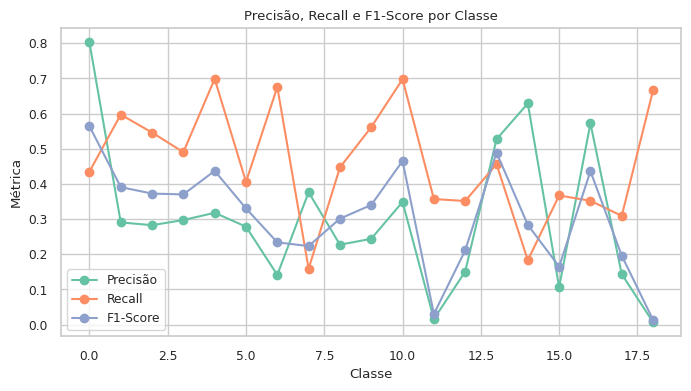

In [49]:
# Plotar precisão, recall e f1-score para cada classe num gráfico bonitinho
classes = list(range(num_classes))
precisions = [tp[i] / (tp[i] + fp[i]) for i in range(num_classes)]
recalls = [tp[i] / (tp[i] + fn[i]) for i in range(num_classes)]
f1_scores = [2 * (precisions[i] * recalls[i]) / (precisions[i] + recalls[i]) for i in range(num_classes)]

plt.figure(figsize=(8, 4))
plt.plot(classes, precisions, label='Precisão', marker='o')
plt.plot(classes, recalls, label='Recall', marker='o')
plt.plot(classes, f1_scores, label='F1-Score', marker='o')
plt.xlabel('Classe')
plt.ylabel('Métrica')
plt.title('Precisão, Recall e F1-Score por Classe')
plt.legend()
plt.show()

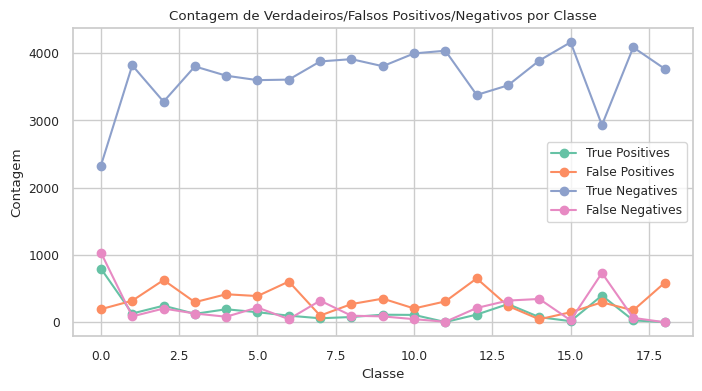

In [47]:
# Plotar num gráfico bonitinho
plt.figure(figsize=(8, 4))
plt.plot(range(num_classes), [tp[i] for i in range(num_classes)], label='True Positives', marker='o')
plt.plot(range(num_classes), [fp[i] for i in range(num_classes)], label='False Positives', marker='o')
plt.plot(range(num_classes), [tn[i] for i in range(num_classes)], label='True Negatives', marker='o')
plt.plot(range(num_classes), [fn[i] for i in range(num_classes)], label='False Negatives', marker='o')
plt.xlabel('Classe')
plt.ylabel('Contagem')
plt.title('Contagem de Verdadeiros/Falsos Positivos/Negativos por Classe')
plt.legend()
plt.show()